Pridiction for n folds where n = 10

Predicted conclusion matrix  [[13, 4], [3, 10]]  Accuracy = 76.66666666666667

Predicted conclusion matrix  [[12, 3], [4, 11]]  Accuracy = 76.66666666666667

Predicted conclusion matrix  [[12, 2], [3, 13]]  Accuracy = 83.33333333333334

Predicted conclusion matrix  [[6, 5], [6, 13]]  Accuracy = 63.33333333333333

Predicted conclusion matrix  [[12, 4], [1, 13]]  Accuracy = 83.33333333333334

Predicted conclusion matrix  [[12, 3], [0, 15]]  Accuracy = 90.0

Predicted conclusion matrix  [[11, 1], [3, 15]]  Accuracy = 86.66666666666667

Predicted conclusion matrix  [[10, 0], [2, 18]]  Accuracy = 93.33333333333333

Predicted conclusion matrix  [[10, 3], [3, 14]]  Accuracy = 80.0

Predicted conclusion matrix  [[9, 4], [1, 16]]  Accuracy = 83.33333333333334

Mean Accuracy : 81.66666666666667
Precision = 0.8263473053892216
Recall = 0.8414634146341463
Average of all conclusion matrix  [[10.7, 2.9], [2.6, 13.8]] 


 Graphical representation of confusion matri

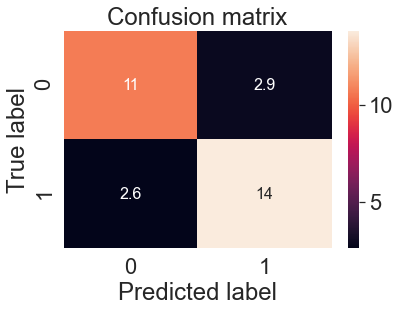

In [1]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	dataset=dataset[1:]
	for i in range(len(dataset)):
		for j in range(len(dataset[0])):
			if i==0 and j==0:
				dataset[i][j]=int(dataset[i][j][-1])
			elif j==9:
				dataset[i][j]=float(dataset[i][j])
			else:
				dataset[i][j]=int(dataset[i][j])
	return dataset

def minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats


def norm(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])


def split(dataset, fold):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / fold)
	for i in range(fold):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

def accuracy_metric(actual, predicted,m):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
		m[actual[i]][predicted[i]]=m[actual[i]][predicted[i]]+1
	return correct / float(len(actual)) * 100.0,m

def algo(dataset, algorithm, fold, *args):
	folds = split(dataset, fold)
	scores = list()
	m=[]
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		mat=[[0,0]for x in range(2)]
		actual = [row[-1] for row in fold]
		accuracy,mat = accuracy_metric(actual, predicted,mat)
		m.append(mat)
		scores.append(accuracy)

	return scores,m

def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

def forward(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

def derivate(output):
	return output * (1.0 - output)

def backerror(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * derivate(neuron['output'])

def update_weights(network, row, learning):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += learning * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += learning * neuron['delta']

def train_n(network, train, learning, n_epoch, output):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward(network, row)
			expected = [0 for i in range(output)]
			expected[row[-1]] = 1
			backerror(network, expected)
			update_weights(network, row, learning)

def ini_network(n, hidden, output):
	network = list()
	hidden_layer = [{'weights':[1/(n+1) for i in range(n + 1)]} for i in range(hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[1/(n+1) for i in range(hidden + 1)]} for i in range(output)]
	network.append(output_layer)
	return network

def predict(network, row):
	outputs = forward(network, row)
	return outputs.index(max(outputs))

def back(train, test, learning, n_epoch, hidden):
	n = len(train[0]) - 1
	output = len(set([row[-1] for row in train]))
	network = ini_network(n, hidden, output)
	train_n(network, train, learning, n_epoch, output)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)

def main():
	filename = 'heart.csv'
	dataset = load_csv(filename)
	var= minmax(dataset)
	norm(dataset, var)
	fold = 10
	learning = 0.2
	n_epoch = 500
	hidden = 5
	scores,m = algo(dataset, back, fold, learning, n_epoch, hidden)
	print("Pridiction for n folds where n = "+str(fold)+"\n")
	for x in range(len(scores)):
		print("Predicted conclusion matrix ",m[x]," Accuracy = "+str(scores[x])+"\n")
	mat=[[0,0] for x in range(2)]
	for x in range(2):
		for y in range(2):
			total=0
			for z in range(len(m)):
				total=total+m[z][x][y]
			total=total/len(m)
			mat[x][y]=total
	print("Mean Accuracy : "+str(sum(scores)/len(scores)))
	print("Precision = "+str(mat[1][1]/(mat[1][1]+mat[0][1])))
	print("Recall = "+str(mat[1][1]/(mat[1][1]+mat[1][0]))) 
	print("Average of all conclusion matrix ",mat,"\n")
	print("\n Graphical representation of confusion matrix")
	df_cm = pd.DataFrame(mat)
	sn.set(font_scale=2)
	sn.color_palette("Blues", as_cmap=True)
	sn.heatmap(df_cm, annot=True,  annot_kws = {"size": 16})
	plt.xlabel('Predicted label')
	plt.title('Confusion matrix')
	plt.ylabel('True label')
	plt.show()
main()







